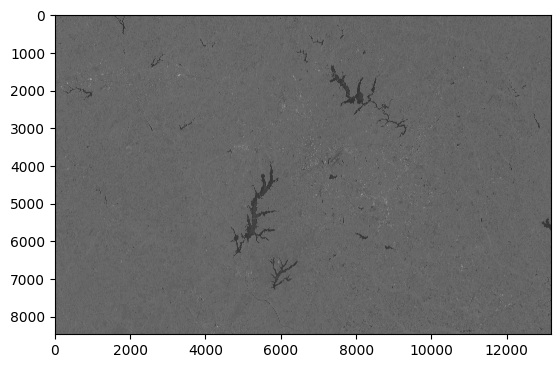

In [7]:
import rasterio
from rasterio.merge import merge
from rasterio.windows import from_bounds
import matplotlib.pyplot as plt

# Define paths to the two images
image1_path = r"C:\Users\leiwang\Downloads\S1_Lee_filter-0000000000-0000000000 (2).tif"
image2_path = r"C:\Users\leiwang\Downloads\S1_Lee_filter-0000000000-0000023296 (1).tif"

# Define the lower-left and upper-right coordinates for clipping (in the image's coordinate system)
# Format: (min_lon, min_lat, max_lon, max_lat)
min_x, min_y = 554364,189819
max_x, max_y = 686091,274500
clip_bounds = (min_x, min_y, max_x, max_y)  # Example: (-50, -20, -30, 0)

# Open the images using Rasterio
with rasterio.open(image1_path) as src1, rasterio.open(image2_path) as src2:
    # Mosaic the two images
    mosaic_array, out_transform = merge([src1, src2])

    # Get the profile (metadata) from one of the images (used later for saving)
    profile = src1.profile

    # Convert the clipping coordinates (bounds) to the pixel window
    window = from_bounds(clip_bounds[0], clip_bounds[1], clip_bounds[2], clip_bounds[3], out_transform)
    
    # Clip the mosaiced image using the window (window will return pixel coordinates)
    mosaic_clipped = mosaic_array[:, int(window.row_off):int(window.row_off + window.height), int(window.col_off):int(window.col_off + window.width)]

    # Update the profile to reflect the new size and transform
    profile.update({
        'height': mosaic_clipped.shape[1],
        'width': mosaic_clipped.shape[2],
        'transform': rasterio.windows.transform(window, out_transform)
    })

# Optionally, visualize the clipped mosaic
plt.imshow(mosaic_clipped[0], cmap='gray')  # Assuming grayscale for visualization
plt.show()

# Save the clipped mosaic as a new file
output_path = r'C:\Users\leiwang\Downloads\clipped_mosaic.tif'
with rasterio.open(output_path, 'w', **profile) as dst:
    dst.write(mosaic_clipped)


In [15]:
lower_left = "554364,189819"
min_x, min_y = map(float,lower_left.split(','))
min_x, min_y

(554364.0, 189819.0)

In [32]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from rasterio.mask import mask
from shapely.geometry import box

# Define the path to the input image
image_path = r"C:\Users\leiwang\Downloads\JCRwaterpixels (3).tif"

# Define the threshold value
threshold_value = 20  # Example threshold, adjust as needed
clip_bounds = (min_x, min_y, max_x, max_y)  # Example: (-50, -20, -30, 0)

# Open the image using rasterio
with rasterio.open(image_path) as src:
    # Read the first band (assuming a single-band image)

    # Apply the threshold to create a binary image
    # Values greater than the threshold become 1 (white), others become 0 (black)
    bbox = box(*clip_bounds)

    clipped_image, clipped_transform = mask(src,[bbox], crop=True, nodata=0)
    
    # Update the clipped image to match the binary transformation
    clipped_image[clipped_image <= threshold_value] = 0
    clipped_image[clipped_image > threshold_value] = 1

    # Define metadata for the new image
    out_meta = src.meta.copy()
    out_meta.update({
        "driver": "GTiff",
        "height": clipped_image.shape[1],
        "width": clipped_image.shape[2],
        "transform": clipped_transform
    })
# Save the binary image to a new file
output_path = r'C:\Users\leiwang\Downloads\binary_clipped1.tif'
with rasterio.open(output_path, 'w', **out_meta) as dst:
    dst.write(clipped_image[0,:,:].astype(rasterio.uint8), 1)  # Save as unsigned 8-bit (0 or 1 values)


In [34]:
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling

# Paths to your two rasters
source_raster_path= r'C:\Users\leiwang\Downloads\jrc_watermask.tif'
target_raster_path  =  r'C:\Users\leiwang\Downloads\sar.tif'
aligned_raster_path =  r'C:\Users\leiwang\Downloads\jrc_watermask1.tif'  # Output path for the aligned raster

# Open the target raster (the one with the desired alignment)
with rasterio.open(target_raster_path) as target_raster:
    # Get target raster properties
    target_transform = target_raster.transform
    target_crs = target_raster.crs
    target_width = target_raster.width
    target_height = target_raster.height
    
    # Open the source raster (the one you want to align)
    with rasterio.open(source_raster_path) as src:
        # Calculate transform and new dimensions based on the target raster
        transform, width, height = calculate_default_transform(
            src.crs, target_crs, src.width, src.height, *src.bounds, dst_width=target_width, dst_height=target_height
        )
        
        # Create a new profile (metadata) for the aligned image
        profile = src.profile
        profile.update({
            'crs': target_crs,
            'transform': transform,
            'width': width,
            'height': height
        })
        
        # Open a new file to write the aligned image
        with rasterio.open(aligned_raster_path, 'w', **profile) as dst:
            for i in range(1, src.count + 1):  # Loop through each band
                reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=target_crs,
                    resampling=Resampling.nearest  # Use nearest neighbor resampling, or choose another method
                )


In [29]:
clipped_image.shape

(1, 8469, 13174)

In [17]:
trans = profile.transform

AttributeError: 'Profile' object has no attribute 'transform'